In [0]:
#!unzip "drive/My Drive/dog breed project/dog-breed-identification.zip" -d "drive/My Drive/dog breed project/"

### Preparing the workspace
* Import Tensorflow
* Import TensorFlow Hub
* Make sure to use a GPU

In [10]:
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("HUB version:", hub.__version__)

#Check for GPU availability
print("GPU", "Available YES!" if tf.config.list_physical_devices("GPU") else "Not available :(") 
# If not available we need to change configs at Runtime > Change Runtime Type and select GPU.


TF version: 2.2.0-rc3
HUB version: 0.8.0
GPU Available YES!


### Getting data ready, turning images into Tenses
* We need our data in numerical format

In [11]:
import pandas as pd
# Check our labels 
labels_csv= pd.read_csv("drive/My Drive/dog breed project/labels.csv")
print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     f9698ad44b009757cfacd9f171310651  scottish_deerhound
freq                                   1                 126


In [12]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


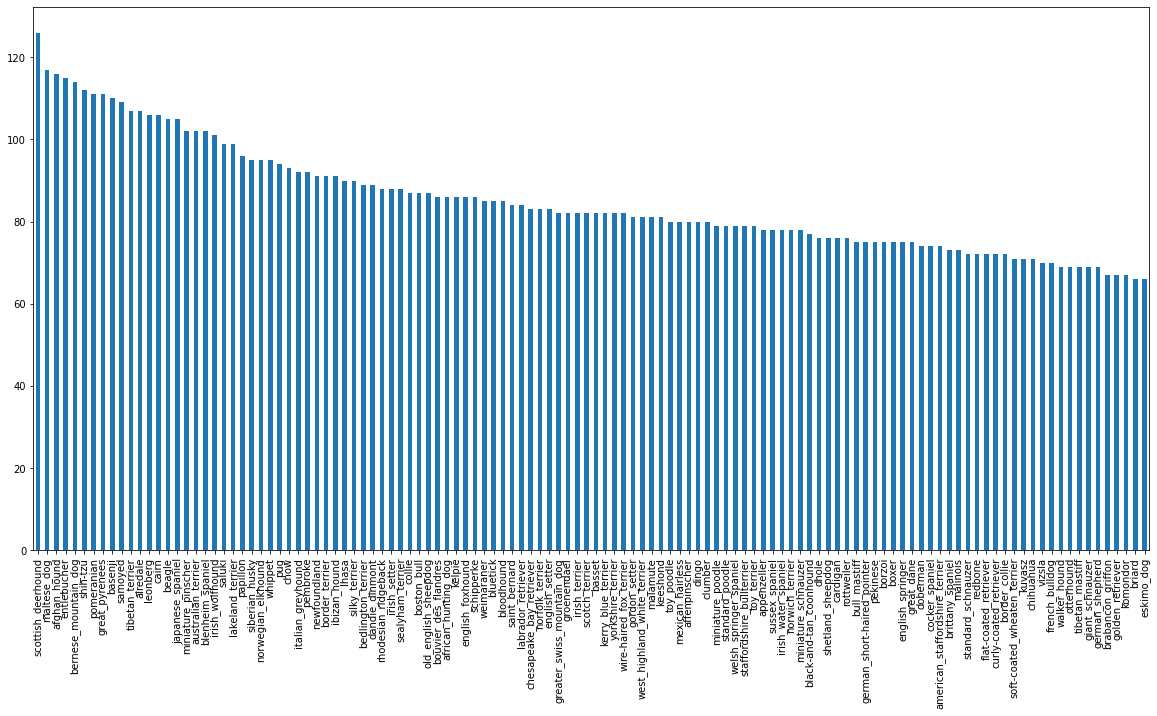

In [13]:
#How many images of each breed?
labels_csv.breed.value_counts().plot.bar(figsize=(20,10))

In [14]:
labels_csv.breed.value_counts().median()

82.0

###Create a list of images based on their pathname

In [15]:
filenames = ["drive/My Drive/dog breed project/train/" + fname + ".jpg" for fname in labels_csv["id"] ]
filenames[:10]

['drive/My Drive/dog breed project/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/dog breed project/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/dog breed project/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/dog breed project/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/dog breed project/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/dog breed project/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/dog breed project/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/dog breed project/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/dog breed project/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/dog breed project/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [16]:
#Check if number of filenames matches the number of actual images
import os

if len(os.listdir("drive/My Drive/dog breed project/train")) == len(filenames):
  print("Filenames match, we may proceed")
else:
  print("Filenames do not match, check target directory")  

Filenames match, we may proceed


In [17]:
from IPython.display import Image
labels_csv[labels_csv["breed"] == "maltese_dog"]

,id,breed
12,00693b8bc2470375cc744a6391d397ec,maltese_dog
90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
164,03dfefdb2939388f7ca9578cb7c4a2b9,maltese_dog
226,053106ed091eac5e129225315ef6cfcb,maltese_dog
238,058ea5b467d08ed978658dc1ad85fb7d,maltese_dog
...,...,...
9778,f61d861726155de0ebd1a8e1e892f5af,maltese_dog
9927,f98392bfae7d0aa35ecc4993ee2afbaf,maltese_dog
9972,fa5054c5187c7171c546bd6a46b8346f,maltese_dog
10200,ff7d9c08091acc3b18b869951feeb013,maltese_dog


### Let`s prepare our labels 
* Turn them into numbers

In [18]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [19]:
#See if number of labels matches number of files
if len(labels) == len(filenames):
  print("They match, we may proceed.")
else:
  print("They do not match, check files")

They match, we may proceed.


In [20]:
#Check the unique breeds
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [21]:
#Turn every line in a boolean array
boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

###Creating our own validation set

In [0]:
# Setting up X and y variables
X = filenames
y = boolean_labels

Start off with about 1000 images and increase if needed

In [23]:
#Set number of images for experiment
NUM_IMAGES = 1000 #@param {type:"slider", min:1000, max:10000}
NUM_IMAGES

1000

In [24]:
#Split data into test and train
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(X_val), len(y_train), len(y_val)

(800, 200, 800, 200)

##Preprocessing images (Turning into Tensors)
*Create a function to:
1. Take an image filepath as input.
2. Use TensorFlow to read the file and store it to a variable `image`.
3. Turn our `image` into Tensors.
4. Resize the `image` to be the shape (224, 224).
5. Return `image`.

In [0]:
IMG_SIZE = 224

def process_image(img_path):
  """
  Takes an image`s filepath and turns it into Tensors
  """
  #Read the file
  image = tf.io.read_file(img_path)
  #Turn the image into a numerical Tensor (REd, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  #Convert color channel values from 0-255 to 0-1 (Normalization for performance purposes)
  image = tf.image.convert_image_dtype(image, tf.float32)
  #Resize the image
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

## Turning data into batches


In [0]:
#Create a function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path and the associated label and
  turns it into a tuple
  """
  image = process_image(image_path)
  return image, label

## Let's write a function to turn all of our data (X & y) into batches.

In [0]:
BATCH_SIZE = 32

def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of X(images) and y(labels) pairs.
  Shuffles data if it's in training but does not if it's in validation.
  """
  if test_data:
    print("Creating test data batch")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x)))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    print("Done")
    return data_batch
  elif valid_data:
    print("Creating validation data batch")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    print("Done")
    return data_batch
  else:
    print("Creating training data batch")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data = data.shuffle(buffer_size=len(x))
    data = data.map(get_image_label)
    print("Done")
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [28]:
#Creating training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batch
Done
Creating validation data batch
Done


In [29]:
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

### Visualizing data batches

In [0]:
#Create a function for viewing data in a data batch
import matplotlib.pyplot as plt

def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch
  """
  #Setup the figure
  plt.figure(figsize=(10, 10))
  #Loop through 25 images
  for i in range(25):
    #Create subplots
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(images[i])
    #Adding the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    #Turn grid lines off
    plt.axis("off")

In [31]:
train_data

<BatchDataset shapes: ((None, 224, 224, 3), (None, 120)), types: (tf.float32, tf.bool)>

In [32]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

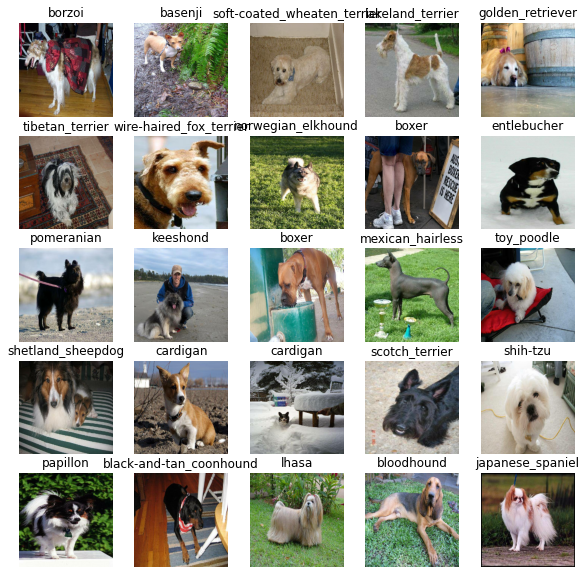

In [33]:
show_25_images(train_images,train_labels)

###Building a model
Before we build a model, there are a few things to define:

* The input shape (images, in the form of Tensors) to our model.
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model to use.

In [0]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_breeds)

# model URL from TensorFlow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

##Create a function which:

* Takes the input shape, output shape and the model we've chosen's URL as parameters.
* Defines the layers in a Keras model in a sequential fashion (do this first, then this, then that).
* Compiles the model (says how it should be evaluated and improved).
* Builds the model (tells it what kind of input shape it'll be getting).
* Returns the model.

In [0]:
#Function to build a keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", model_url)

  #Setup model
  model = tf.keras.Sequential([hub.KerasLayer(model_url, arguments=dict(batch_norm_momentum=0.998)), #input layer
                               tf.keras.layers.Dense(units=OUTPUT_SHAPE, activation="softmax") #output layer
                               ])
  
  #Compile model
  model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), #We want to reduce entropy
                optimizer=tf.keras.optimizers.Adam(), #Something that tells the model how to improve itself
                metrics=["accuracy"] #This should go up
  )

  #Build the model
  model.build(input_shape)

  return model
  

In [36]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  5432713   
_________________________________________________________________
dense (Dense)                multiple                  120240    
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


##Creating callbacks

Callbacks are helper functions a model can use during training to do things such as save a models progress, check a models progress or stop training early if a model stops improving.

The two callbacks we're going to add are a TensorBoard callback and an Early Stopping callback.

###TensorBoard Callback
Helps provide a visual way to monitor the progress of a model during and after training.

It can be used directly in a notebook to track the performance measures of a model such as loss and accuracy.

We need to:

1. Load the TensorBoard notebook extension.
2. Create a TensorBoard callback which is able to save logs to a directory and pass it to our model's `fit()` function.
3. Visualize the our models training logs using the `%tensorboard` magic function (we'll do this later on).

In [0]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [0]:
import datetime

# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("drive/My Drive/Data/logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

###Early Stopping Callback
Helps prevent overfitting by stopping a model when a certain evaluation metric stops improving. Keep finding patterns until the quality of those patterns starts to go down.

In [0]:
# Create early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

##Training a model (on a subset of data)

In [0]:
NUM_EPOCHS = 100 #@param {type:"slider", min:10, max:100, step:10}

In [41]:

# Check again if GPU is available (otherwise computing will take a long time)
print("GPU", "available YES!" if tf.config.list_physical_devices("GPU") else "not available :(")

GPU available YES!


###Create a simple function which trains a model. The function will:

* Create a model using `create_model()`.
* Setup a TensorBoard callback using create_tensorboard_callback() (we do this here so it creates a log directory of the current date and time).
* Call the fit() function on our model passing it the training data, validatation data, number of epochs to train for and the callbacks we'd like to use.
* Return the fitted model.

In [0]:
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  #Creating a model
  model = create_model()
  #Creating a tensorboard instance each time we train a model
  tensorboard = create_tensorboard_callback()
  #Fitting data to our model using our callbacks
  model.fit(x=train_data,
            epochs=NUM_EPOCHS, 
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  
  return model

In [43]:
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 421s 17s/step - loss: 4.5780 - accuracy: 0.0750 - val_loss: 3.3122 - val_accuracy: 0.2950
Epoch 2/100
25/25 [==============================] - 5s 200ms/step - loss: 1.6439 - accuracy: 0.6938 - val_loss: 2.0620 - val_accuracy: 0.4900
Epoch 3/100
25/25 [==============================] - 5s 200ms/step - loss: 0.5603 - accuracy: 0.9438 - val_loss: 1.5829 - val_accuracy: 0.6050
Epoch 4/100
25/25 [==============================] - 5s 200ms/step - loss: 0.2501 - accuracy: 0.9912 - val_loss: 1.4218 - val_accuracy: 0.6150
Epoch 5/100
25/25 [==============================] - 5s 205ms/step - loss: 0.1468 - accuracy: 0.9987 - val_loss: 1.3381 - val_accuracy: 0.6500
Epoch 6/100
25/25 [==============================] - 5s 211ms/step - loss: 0.1008 - accuracy: 0.9987 - val_loss: 1.3026 - val_accuracy: 0.6650
Epoch 7/100
25/25 [==============================


###Checking the TensorBoard logs
We can make its performance visual by checking the TensorBoard logs.
The TensorBoard magic function (%tensorboard) will access the logs directory.

In [44]:
%tensorboard --logdir drive/My\ Drive/Data/logs

<IPython.core.display.Javascript object>

###Making and evaluating predictions using a trained model

In [45]:
predictions = model.predict(val_data, verbose=1) # verbose shows us how long there is to go
predictions

7/7 [==============================] - 1s 128ms/step


array([[2.20711413e-03, 1.03155628e-03, 1.15613965e-03, ...,
        1.76938041e-03, 2.57000764e-04, 2.29851273e-03],
       [4.95139568e-04, 3.70984292e-03, 1.51604915e-03, ...,
        2.34312218e-04, 7.69307837e-04, 1.39322103e-04],
       [5.54405176e-07, 7.23057892e-05, 1.84281944e-05, ...,
        4.09902394e-04, 3.70696512e-06, 4.53434004e-05],
       ...,
       [6.36485038e-06, 8.00159323e-05, 1.08155466e-04, ...,
        8.62325833e-05, 1.14516020e-04, 1.13731534e-04],
       [3.13255703e-03, 3.59071884e-04, 4.48331411e-04, ...,
        1.84177159e-04, 1.24164071e-04, 2.13934928e-02],
       [4.60800366e-04, 7.90927734e-05, 6.10606279e-04, ...,
        1.36357993e-02, 1.22843357e-03, 1.62778961e-05]], dtype=float32)

In [46]:
# Check the shape of predictions
predictions.shape

(200, 120)

These different values are the probabilities or the likelihood the model has predicted a certain image being a certain breed of dog. The higher the value, the more likely the model thinks a given image is a specific breed of dog.

##Let's convert an array of probabilities into an actual label.

In [47]:
# First prediction
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}") # the max probability value predicted by the model
print(f"Sum: {np.sum(predictions[0])}") # because we used softmax activation in our model, this will be close to 1
print(f"Max index: {np.argmax(predictions[0])}") # the index of where the max value in predictions[0] occurs
print(f"Predicted label: {unique_breeds[np.argmax(predictions[0])]}") # the predicted label

[2.2071141e-03 1.0315563e-03 1.1561397e-03 1.0398179e-04 3.7386903e-04
 6.7049339e-05 3.1438850e-02 9.6173264e-04 1.7959195e-04 3.4004627e-04
 9.3935418e-04 6.3459091e-05 2.2495500e-04 2.7726875e-05 1.2126885e-04
 6.4431306e-04 8.2303130e-05 1.5470217e-01 3.3293202e-04 1.7179042e-05
 7.1097940e-04 1.4795164e-04 3.0926400e-05 4.1382154e-03 3.6720863e-05
 4.3348908e-05 1.9093460e-01 9.7622571e-05 1.9888431e-03 3.0771803e-04
 2.4308678e-05 2.6474991e-03 2.9098199e-04 9.7401855e-05 1.4732346e-04
 6.4488567e-02 9.8779303e-05 8.3896804e-05 9.7632954e-05 1.5307739e-04
 1.1847074e-03 1.8324772e-05 1.8327718e-04 8.9551686e-05 4.6370742e-06
 1.2682205e-04 1.1202435e-05 6.2571795e-05 4.1430010e-04 3.7453585e-05
 5.3078146e-04 1.4130581e-05 3.8518530e-04 1.2832349e-04 1.6482043e-04
 1.5685015e-05 3.6336620e-05 1.7526574e-03 3.0915980e-04 3.1413410e-02
 2.2163917e-03 3.0002040e-05 2.1404666e-03 1.1773660e-04 1.8844531e-04
 2.9876840e-03 6.7288114e-04 7.6054384e-05 3.0639261e-02 6.5656996e-04
 1.320

##Function to convert prediction probabilities into predicted labels.

In [48]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

# Get a predicted label based on an array of prediction probabilities
pred_label = get_pred_label(predictions[101])
pred_label

'bernese_mountain_dog'

Our validation data (val_data) is in batch form, to get a list of validation images and labels, we'll have to unbatch it (using `unbatch()`) and then turn it into an iterator using `as_numpy_iterator()`.

In [49]:
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns separate arrays
  of images and labels.
  """
  images= []
  labels= []

  #Loop through bartched data
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images,labels

# Unbatchify the validation data
val_images, val_labels = unbatchify(val_data)
val_images[0], val_labels[0]  

(array([[[0.29599646, 0.43284872, 0.3056691 ],
         [0.26635826, 0.32996926, 0.22846507],
         [0.31428418, 0.2770141 , 0.22934894],
         ...,
         [0.77614343, 0.82320225, 0.8101595 ],
         [0.81291157, 0.8285351 , 0.8406944 ],
         [0.8209297 , 0.8263737 , 0.8423668 ]],
 
        [[0.2344871 , 0.31603682, 0.19543913],
         [0.3414841 , 0.36560842, 0.27241898],
         [0.45016077, 0.40117094, 0.33964607],
         ...,
         [0.7663987 , 0.8134138 , 0.81350833],
         [0.7304248 , 0.75012016, 0.76590735],
         [0.74518913, 0.76002574, 0.7830809 ]],
 
        [[0.30157745, 0.3082587 , 0.21018331],
         [0.2905954 , 0.27066195, 0.18401104],
         [0.4138316 , 0.36170745, 0.2964005 ],
         ...,
         [0.79871625, 0.8418535 , 0.8606443 ],
         [0.7957738 , 0.82859945, 0.8605655 ],
         [0.75181633, 0.77904975, 0.8155256 ]],
 
        ...,
 
        [[0.9746779 , 0.9878955 , 0.9342279 ],
         [0.99153054, 0.99772066, 0.94278

##We want to be able to view an image, its predicted label and its actual label (true label).

Create a function to:

* Take an array of prediction probabilities, an array of truth labels, an array of images and an integer.
* Convert the prediction probabilities to a predicted label.
* Plot the predicted label, its predicted probability, the truth label and target image on a single plot.

In [0]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]

  #Get the predicted label
  pred_label = get_pred_label(pred_prob)

  #Plot image and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  #Change the color of the title depending if the prediction was wright or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ({})".format(pred_label,
                                      np.max(pred_prob)*100,
                                      true_label),
                                      color=color)    

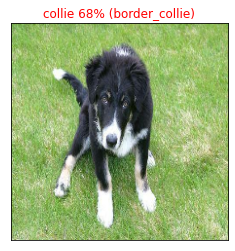

In [51]:
#Example of prediction, true label and image
plot_pred(prediction_probabilities=predictions, labels=val_labels, images=val_images, n=9)

Since we're working with a multi-class problem (120 different dog breeds), it would also be good to see what other guesses our model is making.

Build a function to demonstrate it. The function will:

* Take an input of a prediction probabilities array, a ground truth labels array and an integer.
* Find the predicted label using `get_pred_label()`.
* Find the top 10:
 * Prediction probabilities indexes
 * Prediction probabilities values
 * Prediction labels
* Plot the top 10 prediction probability values and labels, coloring the true label green.

In [0]:
def plot_pred_conf(prediction_probabilities, labels, n=1):
  """
  Plots the top 10 prediction confidences along with ground true label for sample `n`
  """
  pred_prob, true_label = prediction_probabilities[n], labels[n]

  pred_label = get_pred_label(prediction_probabilities=pred_prob)

  top_10_pred_indexes = pred_prob.argsort()[-10:][::-1]
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  top_10_pred_labels = unique_breeds[top_10_pred_indexes]

  # Setup plot
  top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                     top_10_pred_values, 
                     color="grey")
  plt.xticks(np.arange(len(top_10_pred_labels)),
             labels=top_10_pred_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_pred_labels):
    top_plot[np.argmax(top_10_pred_labels == true_label)].set_color("green")
  else:
    pass

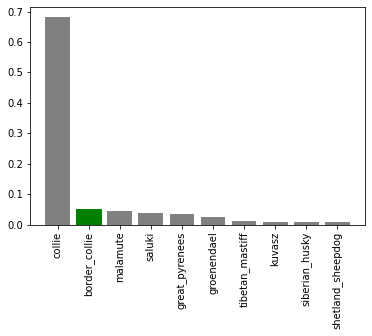

In [53]:
plot_pred_conf(prediction_probabilities=predictions, labels=val_labels, n=9)

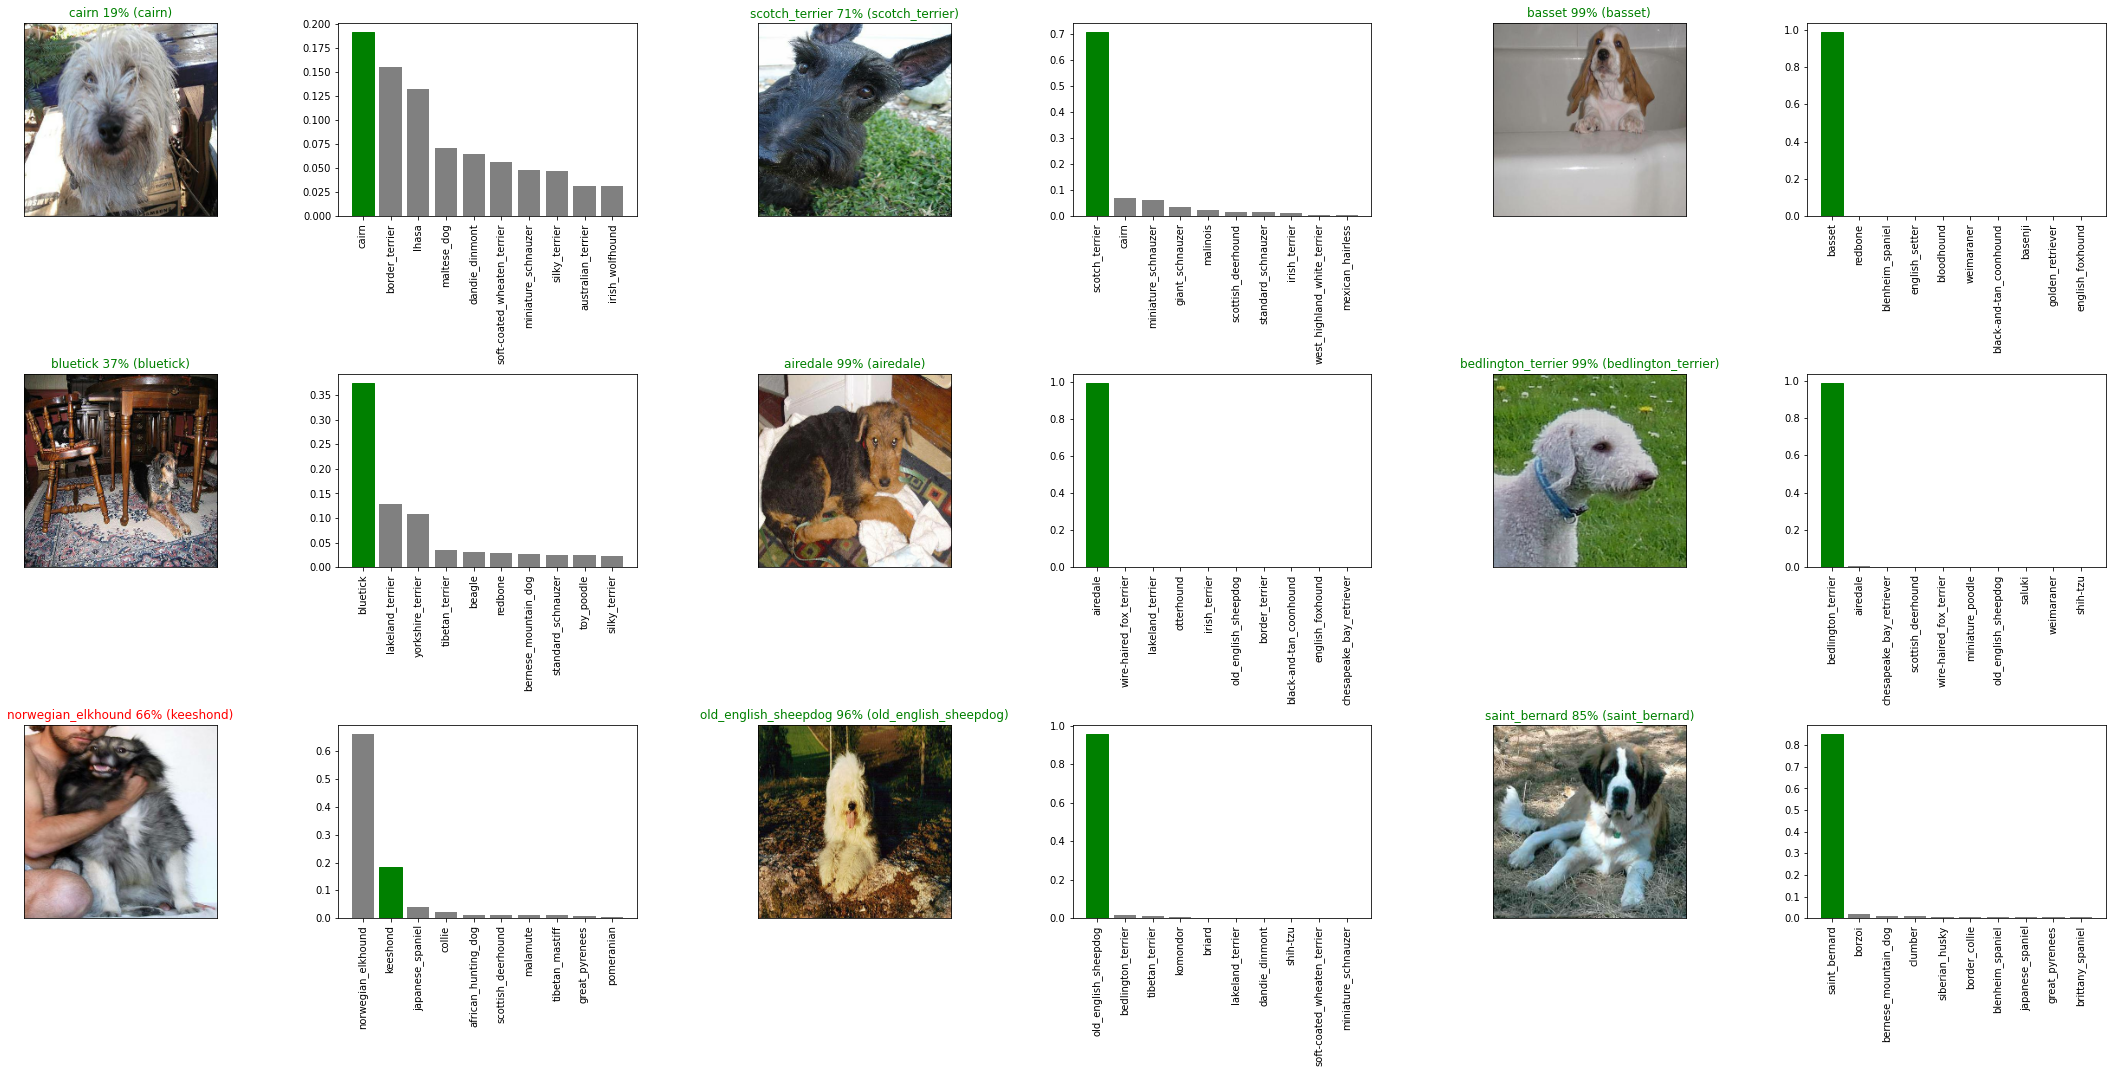

In [54]:
# Let's check a few predictions and their different values
i_multiplier = 0
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(5*2*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=val_labels,
            images=val_images,
            n=i+i_multiplier)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(prediction_probabilities=predictions,
                labels=val_labels,
                n=i+i_multiplier)
plt.tight_layout(h_pad=1.0)
plt.show()

##Saving and reloading a model
The format of an entire saved Keras model is h5. So we'll make a function which can take a model as input and utilise the save() method to save it as a h5 file to a specified directory.

In [0]:
def save_model(model, suffix=None):
  """
  Saves a given model in a models directory and appends a suffix (str)
  for clarity and reuse.
  """
  # Create model directory with current time
  modeldir = os.path.join("drive/My Drive/Data/models",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5" # save format of model
  print(f"Saving model to: {model_path}...")
  model.save(model_path)
  return model_path

Create a function which can take a model path and use the `tf.keras.models.load_model()` function to load it into the notebook.

Because we're using a component from TensorFlow Hub (hub.KerasLayer) we'll have to pass this as a parameter to the `custom_objects` parameter.

In [0]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [57]:
# Save our model trained on 1000 images
save_model(model, suffix="1000-images-mobilenet_v2_classif_Adam")

Saving model to: drive/My Drive/Data/models/20200428-00411588034488-1000-images-mobilenet_v2_classif_Adam.h5...


'drive/My Drive/Data/models/20200428-00411588034488-1000-images-mobilenet_v2_classif_Adam.h5'

In [0]:
# Load our model trained on 1000 images
#model_1000_images = load_model('drive/My Drive/Data/models/20200131-02551580439347-1000-images-Adam.h5')

##Training a model (on the full data)

In [59]:
# Turn full training data in a data batch
full_data = create_data_batches(X, y)

Creating training data batch
Done


In [60]:
# Instantiate a new model for training on the full dataset
full_model = create_model()

# Create full model callbacks

# TensorBoard callback
full_model_tensorboard = create_tensorboard_callback()

# Early stopping callback
# Note: No validation set when training on all the data, therefore can't monitor validation accuracy
full_model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                             patience=3)

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4


In [0]:
# Fit the full model to the full training data - It takes a loooooong time
full_model.fit(x=full_data,
               epochs=NUM_EPOCHS,
               callbacks=[full_model_tensorboard, 
                          full_model_early_stopping])

Epoch 1/100
154/320 [=============>................] - ETA: 38:43 - loss: 1.9475 - accuracy: 0.5627

In [0]:
# Save model to file
save_model(full_model, suffix="all-images-Adam-tunned")

In [0]:
# Load in the full model
loaded_full_model = load_model('drive/My Drive/Data/models/20200427-16091588003797-all-images-Adam.h5')

##Making predictions on the test dataset
To make predictions on the test data, we'll:

* Get the test image filenames.
* Convert the filenames into test data batches using `create_data_batches()` and setting the test_data parameter to True (since there are no labels with the test images).
* Make a predictions array by passing the test data batches to the `predict()` function.

In [0]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "drive/My Drive/dog breed project/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

In [0]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

In [0]:
# Make predictions on test data batch using the loaded full model
test_predictions = loaded_full_model.predict(test_data,
                                             verbose=1)

In [0]:
test_predictions

##Making predictions on custom images
To do so, we'll:

* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the test_data parameter to True.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to prediction labels.
* Compare the predicted labels to the custom images.

In [0]:
# Get custom image filepaths
custom_path = "drive/My Drive/Fotos/Dogs/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]
custom_image_paths

In [0]:
# Turn custom image into batch (set to test data because there are no labels)
custom_data = create_data_batches(custom_image_paths, test_data=True)

In [0]:
# Make predictions on the custom data
custom_preds = loaded_full_model.predict(custom_data)

In [0]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

In [0]:
# Get custom images (our unbatchify() function won't work since there aren't labels)
custom_images = []
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

In [0]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(1, 3, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

##What's next?

1. [Trying another model from TensorFlow Hub](https://tfhub.dev/) - Perhaps a different model would perform better on our dataset. One option would be to experiment with a different pretrained model from TensorFlow Hub or look into the tf.keras.applications module.
2. [Data augmentation](https://bair.berkeley.edu/blog/2019/06/07/data_aug/) - Take the training images and manipulate (crop, resize) or distort them (flip, rotate) to create even more training data for the model to learn from. Check out the [TensorFlow images](https://www.tensorflow.org/api_docs/python/tf/image) documentation for a whole bunch of functions you can use on images. A great idea would be to try and replicate the techniques in [this example cat vs. dog image classification notebook](https://github.com/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb) for our dog breeds problem.
3. [Fine-tuning](https://www.tensorflow.org/hub/tf2_saved_model#fine-tuning) - The model we used in this notebook was directly from TensorFlow Hub, we took what it had already learned from another dataset (ImageNet) and applied it to our own. Another option is to use what the model already knows and fine-tune this knowledge to our own dataset (pictures of dogs). This would mean all of the patterns within the model would be updated to be more specific to pictures of dogs rather than general images.

One of the best ways to find out something is to search for something like:
* "How to improve a TensorFlow 2.x image classification model?"
* "TensorFlow 2.x image classification best practices"
* "Transfer learning for image classification with TensorFlow 2.x"